In [1]:
import pygsti
from pygsti.circuits import Circuit
import random
from pygsti.modelpacks import smq1Q_XYZI as std
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from pygsti.tools.lindbladtools import *
from pygsti.baseobjs.basisconstructors import id2x2, sigmax, sigmay, sigmaz
from pygsti.modelmembers.operations import LindbladErrorgen
from tqdm import tqdm
SigX = np.array([[0, 1], [1, 0]], dtype=complex)
SigY = np.array([[0, -1j], [1j, 0]], dtype=complex)
SigZ = np.array([[1, 0], [0, -1]], dtype=complex)

/Users/cnammour/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import numpy as _np
import scipy.sparse as _sps

from pygsti.tools import matrixtools as _mt
from pygsti.tools.basistools import basis_matrices

In [3]:
def create_elementary_errorgen_pp(typ, p, q=None, sparse=False):
    """
    Construct an elementary error generator as a matrix in the "pauli product" basis.
    There are four different types of elementary error generators: 'H' (Hamiltonian),
    'S' (stochastic), 'C' (correlation), and 'A' (active).  See arxiv:2103.01928.
    Each type transforms an input density matrix differently.  The action of an elementary
    error generator `L` on an input density matrix `rho` is given by:
    Hamiltonian:  `L(rho) = -1j * [ p, rho ]`
    Stochastic:   `L(rho) = p * rho * p - rho
    Correlation:  `L(rho) = p * rho * q + q * rho * p - 0.5 {{p,q}, rho}
    Active:       `L(rho) = 1j( p * rho * q - q * rho * p + 0.5 {[p,q], rho} )
    Square brackets denotes the commutator and curly brackets the anticommutator.
    `L` is returned as a superoperator matrix that acts on vectorized density matrices.
    Parameters
    ----------
    typ : {'H','S','C','A'}
        The type of error generator to construct.
    p : numpy.ndarray
        d-dimensional basis matrix.
    q : numpy.ndarray, optional
        d-dimensional basis matrix; must be non-None if and only if `typ` is `'C'` or `'A'`.
    sparse : bool, optional
        Whether to construct a sparse or dense (the default) matrix.
    Returns
    -------
    ndarray or Scipy CSR matrix
    """
    d = p.shape[0]; d2 = d**2
    if sparse:
        elem_errgen = _sps.lil_matrix((d2, d2), dtype=p.dtype)
    else:
        elem_errgen = _np.empty((d2, d2), dtype=p.dtype)

    assert(typ in ('H', 'S', 'C', 'A')), "`typ` must be one of 'H', 'S', 'C', or 'A'"
    assert((typ in 'HS' and q is None) or (typ in 'CA' and q is not None)), \
        "Wrong number of basis elements provided for %s-type elementary errorgen!" % typ

    pdag = p.T.conjugate()
    qdag = q.T.conjugate() if (q is not None) else None

    if typ in 'CA':
        pq_plus_qp = pdag @ q + qdag @ p
        pq_minus_qp = pdag @ q - qdag @ p

    # Loop through the standard basis as all possible input density matrices
    for i, rho0 in enumerate(basis_matrices('std', d2)):  # rho0 == input density mx
        # Only difference between H/S/C/A is how they transform input density matrices
        if typ == 'H':
            rho1 = -1j * (p @ rho0 - rho0 @ p)  # Add "/2" to have PP ham gens match previous versions of pyGSTi
        elif typ == 'S':
            pdag_p = (pdag @ p)
            rho1 = p @ rho0 @ pdag - 0.5 * (pdag_p @ rho0 + rho0 @ pdag_p)
        elif typ == 'C':
            rho1 = p @ rho0 @ qdag + q @ rho0 @ pdag - 0.5 * (pq_plus_qp @ rho0 + rho0 @ pq_plus_qp)
        elif typ == 'A':
            rho1 = 1j * (p @ rho0 @ qdag - q @ rho0 @ pdag + 0.5 * (pq_minus_qp @ rho0 + rho0 @ pq_minus_qp))

        elem_errgen[:, i] = rho1.flatten()[:, None] if sparse else rho1.flatten()

    if sparse: elem_errgen = elem_errgen.tocsr()
    return np.round(pygsti.tools.change_basis(elem_errgen, 'std', 'pp'), 12)

def create_elementary_errorgen_dual_pp(typ, p, q=None, sparse=False, normalization_factor='auto'):
    """
    Construct a "dual" elementary error generator matrix in the "pauli product"  basis.
    The elementary error generator that is dual to the one computed by calling
    :function:`create_elementary_errorgen` with the same argument.  This dual element
    can be used to find the coefficient of the original, or "primal" elementary generator.
    For example, if `A = sum(c_i * E_i)`, where `E_i` are the elementary error generators given
    by :function:`create_elementary_errorgen`), then `c_i = dot(D_i.conj(), A)` where `D_i`
    is the dual to `E_i`.
    There are four different types of dual elementary error generators: 'H' (Hamiltonian),
    'S' (stochastic), 'C' (correlation), and 'A' (active).  See arxiv:2103.01928.
    Each type transforms an input density matrix differently.  The action of an elementary
    error generator `L` on an input density matrix `rho` is given by:
    Hamiltonian:  `L(rho) = -1j/(2d^2) * [ p, rho ]`
    Stochastic:   `L(rho) = 1/(d^2) p * rho * p
    Correlation:  `L(rho) = 1/(2d^2) ( p * rho * q + q * rho * p)
    Active:       `L(rho) = 1j/(2d^2) ( p * rho * q - q * rho * p)
    where `d` is the dimension of the Hilbert space, e.g. 2 for a single qubit.  Square
    brackets denotes the commutator and curly brackets the anticommutator.
    `L` is returned as a superoperator matrix that acts on vectorized density matrices.
    Parameters
    ----------
    typ : {'H','S','C','A'}
        The type of dual error generator to construct.
    p : numpy.ndarray
        d-dimensional basis matrix.
    q : numpy.ndarray, optional
        d-dimensional basis matrix; must be non-None if and only if `typ` is `'C'` or `'A'`.
    sparse : bool, optional
        Whether to construct a sparse or dense (the default) matrix.
    Returns
    -------
    ndarray or Scipy CSR matrix
    """
    d = p.shape[0]; d2 = d**2
    pdag = p.T.conjugate()
    qdag = q.T.conjugate() if (q is not None) else None

    if sparse:
        elem_errgen = _sps.lil_matrix((d2, d2), dtype=p.dtype)
    else:
        elem_errgen = _np.empty((d2, d2), dtype=p.dtype)

    assert(typ in ('H', 'S', 'C', 'A')), "`typ` must be one of 'H', 'S', 'C', or 'A'"
    assert((typ in 'HS' and q is None) or (typ in 'CA' and q is not None)), \
        "Wrong number of basis elements provided for %s-type elementary errorgen!" % typ

    # Loop through the standard basis as all possible input density matrices
    for i, rho0 in enumerate(basis_matrices('std', d2)):  # rho0 == input density mx
        # Only difference between H/S/C/A is how they transform input density matrices
        if typ == 'H':
            rho1 = -1j * (p @ rho0 - rho0 @ p)  # -1j / (2 * d2) *
        elif typ == 'S':
            rho1 = (p @ rho0 @ pdag)  # 1 / d2 *
        elif typ == 'C':
            rho1 = (p @ rho0 @ qdag + q @ rho0 @ pdag)  # 1 / (2 * d2) *
        elif typ == 'A':
            rho1 = 1j * (p @ rho0 @ qdag - q @ rho0 @ pdag)  # 1j / (2 * d2)
        elem_errgen[:, i] = rho1.flatten()[:, None] if sparse else rho1.flatten()

    return_normalization = bool(normalization_factor == 'auto_return')
    if normalization_factor in ('auto', 'auto_return'):
        primal = create_elementary_errorgen(typ, p, q, sparse)
        if sparse:
            normalization_factor = _np.vdot(elem_errgen.toarray().flatten(), primal.toarray().flatten())
        else:
            normalization_factor = _np.vdot(elem_errgen.flatten(), primal.flatten())
    elem_errgen *= _np.real_if_close(1 / normalization_factor).item()  # item() -> scalar
    elem_errgen = np.round(pygsti.tools.change_basis(elem_errgen, 'std', 'pp'), 12)

    if sparse: elem_errgen = elem_errgen.tocsr()
    return (elem_errgen, normalization_factor) if return_normalization else elem_errgen

In [4]:
def pstr_to_mat(pstr):
    pmat = 1
    for pchar in pstr:
        if pchar == 'X':
            pmat = np.kron(pmat, SigX)
        elif pchar == 'Y':
            pmat = np.kron(pmat, SigY)
        elif pchar == 'Z':
            pmat = np.kron(pmat, SigZ)
        else:
            pmat = np.kron(pmat, np.array([[1, 0], [0, 1]], dtype=complex))
    return pmat

def egenlbl_to_mat(lbl, num_qubits):
    egen_type = lbl.errorgen_type
    egen_basis_lbls = lbl.basis_element_labels
    egen_support = lbl.support
    # convert the basis labels into Pauli strings
    pstr1 = ['I']*num_qubits
    for i, pchar in enumerate(egen_basis_lbls[0]):
        pstr1[egen_support[i]] = pchar
    pstr1 = ''.join(pstr1)
    pmat1 = pstr_to_mat(pstr1)
    if egen_type in 'CA':
        pstr2 = ['I']*num_qubits
        for i, pchar in enumerate(egen_basis_lbls[1]):
            pstr2[egen_support[i]] = pchar
        pstr2 = ''.join(pstr2)
        pmat2 = pstr_to_mat(pstr2)
        return create_elementary_errorgen_pp(egen_type, pmat1, pmat2)
    else:
        return create_elementary_errorgen_pp(egen_type, pmat1)
    
def egenlbl_to_dual(lbl, num_qubits):
    egen_type = lbl.errorgen_type
    egen_basis_lbls = lbl.basis_element_labels
    egen_support = lbl.support
    # convert the basis labels into Pauli strings
    pstr1 = ['I']*num_qubits
    for i, pchar in enumerate(egen_basis_lbls[0]):
        pstr1[egen_support[i]] = pchar
    pstr1 = ''.join(pstr1)
    pmat1 = pstr_to_mat(pstr1)
    if egen_type in 'CA':
        pstr2 = ['I']*num_qubits
        for i, pchar in enumerate(egen_basis_lbls[1]):
            pstr2[egen_support[i]] = pchar
        pstr2 = ''.join(pstr2)
        pmat2 = pstr_to_mat(pstr2)
        return create_elementary_errorgen_dual_pp(egen_type, pmat1, pmat2)
    else:
        return create_elementary_errorgen_dual_pp(egen_type, pmat1)

In [5]:
# dual basis returns a negative rate ???
print(np.trace(create_elementary_errorgen_pp('A', SigZ, SigX)@create_elementary_errorgen_dual_pp('A', SigZ, SigX)))
# seems to work for conjugate of the dual
print(np.trace(create_elementary_errorgen_pp('A', SigZ, SigX).conj().T@create_elementary_errorgen_dual_pp('A', SigZ, SigX)))

-1.0
1.0


In [6]:
class ErrorGen():
    """
    Implements the small Markovian taxonomy
    
    Parameters:
        -features: pauli transfer representations for different error processes
        -rates: sympy vector of rates
    """
    
    def __init__(self, num_qubits, gate_label=('G', 0), parameterization='HSCA'):
        """
        setup the feature dictionary with keys that are sympy variables
        
        right now, I'm doing this by hand for a 1 qubit model, 
        TODO: implement logic to generalize to n-qubits
        """
        self.num_qubits = num_qubits
        self.feature_map = dict()
        self.param_map = dict()
        self.labels =  LindbladErrorgen.from_error_generator(4**num_qubits).coefficient_labels()
        for lbl in self.labels:
            self.feature_map[lbl] = egenlbl_to_mat(lbl, num_qubits)
            if len(lbl.basis_element_labels) > 1:
                pstr = lbl.basis_element_labels[0] + 'x' + lbl.basis_element_labels[1]
                pmat1 = pstr_to_mat(lbl.basis_element_labels[0])
                pmat2 = pstr_to_mat(lbl.basis_element_labels[1])
            else:
                pstr = lbl.basis_element_labels[0]
                pmat = pstr_to_mat(lbl.basis_element_labels[0])
            if len(gate_label) > 1:
                gstr = str(gate_label[0]) + 'q' + str(gate_label[1])
            else:
                gstr = gate_label[0]
            symbol_string = f'{{{lbl.errorgen_type}}}^{{{pstr}}}_{{{gstr}}} '
            self.param_map[lbl] = sp.symbols(symbol_string)
    
            
    @property
    def vec(self):
        return list(self.param_map.values())
    
    @property
    def mat(self):
        mat = np.zeros((4**self.num_qubits, 4**self.num_qubits), dtype='O')
        for x in self.labels:
            mat += self.param_map[x]*self.feature_map[x]
        return sp.Matrix(mat)
    
    @property
    def features(self):
        return [f for f in self.feature_map.values()]
    
    def extract_rates(self):
        rates = dict()
        gen = self.mat
        for lbl in tqdm(self.labels):
            dgen = egenlbl_to_dual(lbl, self.num_qubits)
            rates[lbl] = np.trace(dgen.conj().T@gen)
        return rates
        

In [7]:
egen = ErrorGen(2)

In [8]:
"""check that the basis is well defined"""
egen.extract_rates()

100%|██████████| 240/240 [00:54<00:00,  4.44it/s]


{('H', ('X',), (1,)): 1.0*{H}^{X}_{Gq0},
 ('H', ('Y',), (1,)): 1.0*{H}^{Y}_{Gq0},
 ('H', ('Z',), (1,)): 1.0*{H}^{Z}_{Gq0},
 ('H', ('X',), (0,)): 1.0*{H}^{X}_{Gq0},
 ('H', ('XX',), (0, 1)): 1.0*{H}^{XX}_{Gq0},
 ('H', ('XY',), (0, 1)): 1.0*{H}^{XY}_{Gq0},
 ('H', ('XZ',), (0, 1)): 1.0*{H}^{XZ}_{Gq0},
 ('H', ('Y',), (0,)): 1.0*{H}^{Y}_{Gq0},
 ('H', ('YX',), (0, 1)): 1.0*{H}^{YX}_{Gq0},
 ('H', ('YY',), (0, 1)): 1.0*{H}^{YY}_{Gq0},
 ('H', ('YZ',), (0, 1)): 1.0*{H}^{YZ}_{Gq0},
 ('H', ('Z',), (0,)): 1.0*{H}^{Z}_{Gq0},
 ('H', ('ZX',), (0, 1)): 1.0*{H}^{ZX}_{Gq0},
 ('H', ('ZY',), (0, 1)): 1.0*{H}^{ZY}_{Gq0},
 ('H', ('ZZ',), (0, 1)): 1.0*{H}^{ZZ}_{Gq0},
 ('S', ('X',), (1,)): 1.0*{S}^{X}_{Gq0},
 ('C', ('X', 'Y'), (1,)): 1.0*{C}^{XxY}_{Gq0},
 ('A', ('X', 'Y'), (1,)): 1.0*{A}^{XxY}_{Gq0},
 ('C', ('X', 'Z'), (1,)): 1.0*{C}^{XxZ}_{Gq0},
 ('A', ('X', 'Z'), (1,)): 1.0*{A}^{XxZ}_{Gq0},
 ('C', ('IX', 'XI'), (0, 1)): 1.0*{C}^{IXxXI}_{Gq0},
 ('A', ('IX', 'XI'), (0, 1)): 1.0*{A}^{IXxXI}_{Gq0},
 ('C', ('IX', 

In [9]:
class GateSet():
    """
    Holds the information for
        -all native gates, states, and measurements
        -all error generator features (in a feature dict)
        -map between gate labels and parameter index list (index set)
        -map between parameter indices and error features (feature dict) 
        
    TODO: generalize to n-qubits
    """
    def __init__(self, model_pack):
        # A list of error rates, each one corresponding to one feature in the above list
        self.rates = []
        self.feature_map = dict() # maps variables to their associated feature
        self.egen_from_label = dict() # maps gate labels to error generators
        self.target_model = model_pack.target_model('CPTP')
        self.gate_labels = model_pack.gates
        self.num_qubits = model_pack.processor_spec().num_qubits
        
        # Errors generators for all gates in the model
        for gate in model_pack.gates:
            if len(gate) <= 1:
                egen = ErrorGen(self.num_qubits, (gate, ''))
            else:
                egen = ErrorGen(self.num_qubits, gate)
            self.egen_from_label[gate] = egen
            self.rates += egen.vec
            self.feature_map.update(egen.feature_map)
        # Errors for all measurements in the model
        for povm in self.target_model.povms.keys():
            egen = ErrorGen(self.num_qubits, (povm, 'M'))
            self.egen_from_label[povm] = egen
            self.rates += egen.vec
            self.feature_map.update(egen.feature_map)
        # Errors for all state preparations in the model
        for prep in self.target_model.preps.keys():
            egen = ErrorGen(self.num_qubits, (prep, 'P'))
            self.egen_from_label[prep] = egen
            self.rates += egen.vec
            self.feature_map.update(egen.feature_map)
            
    @property
    def vec(self):
        return self.rates
    
    def features_of(self, op_label):
        """Returns the list of error features associated with the given gate/POVM/state-prep"""
        return self.egen_from_label[op_label].features
    
    def rates_of(self, op_label):
        """Returns the list of error rates associated with the given gate/POVM/state-prep"""
        return self.egen_from_label[op_label].vec
    
    def error_generator_of(self, op_label):
        """Returns the error generator matrix associated with the given gate/POVM/state-prep"""
        return self.egen_from_label[op_label].mat
    
    def target_op(self, op_label):
        """
        returns the target operation of the given operation
        """
        return self.target_model[op_label].to_dense()

    def native_meas(self):
        return [m.to_dense() for m in self.target_model['Mdefault'].values()]

    def rho0(self):
        return self.target_model['rho0'].to_dense()


In [321]:
from scipy.linalg import expm, logm

class CircuitAnalyzer:
    """Performs operations on a given pygsti Circuit object,
    which is part of a given GateSet.
    
    The Circuit's state prep and measurement operators are set to the default values,
    but can be specified by their names, as long as they are part of the GateSet."""
    def __init__(self, circuit, gateset, state_prep='rho0', povm='Mdefault'):
        self.gateset = gateset
        self.circuit = circuit
        # Extracts the gates in the circuit as a list of labels
        self.gates = list(circuit.layertup)
        # Finds their PTMs (pauli transfer matrices)
        self.gate_matrices = [gateset.target_op(gate) for gate in self.gates]
        # Extracts the error matrices corresponding to each of these gates
        self.gate_errors = [gateset.error_generator_of(gate) for gate in self.gates]
        # Also extracts the error terms corresponding to SPAM (state prep + measurement)
        self.state_prep_error = gateset.error_generator_of(state_prep)
        self.povm_error = gateset.error_generator_of(povm)
        
    def left_errors(self):
        """Moves all gate errors to the left of the circuit,
        and returns the resulting list of conjugated error generators.
        
        NOTE: In our Circuit object, the gates are ordered
        left-to-right from first-applied to last-applied.
        However, the error terms in the result of this function, are ordered
        left-to-right as they would be in matrix multiplication."""
        
        left_errors = []
        # The first error in the result is the measurement error,
        # which is unchanged (doesn't need conjugating)
        left_errors.append(self.povm_error)
        # Next, process the gate errors from the end of the list to its beginning
        # Because that's the order they'll appear in the resulting matrix mult
        n = len(self.gate_errors)
        for i in range(n-1, -1, -1):
            error = self.gate_errors[i]
            # Conjugate by all gates being applied after i: gates i+1 through n
            for j in range(i+1, n):
                gate_matrix = self.gate_matrices[j].round(10)
                error = gate_matrix * error * np.linalg.inv(gate_matrix)
            left_errors.append(error)
        # Finally, add the State prep error;
        # We must conjugate it through all gates in the circuit
        error = self.state_prep_error
        for j in range(n):
            gate_matrix = self.gate_matrices[j].round(10)
            error = gate_matrix * error * np.linalg.inv(gate_matrix)
        left_errors.append(error)
        return left_errors
    
    def linear_F_map(self):
        """Returns the linear approximation of the F map,
        after moving all errors to the left. This approximation assumes they commute.
        The result is a function of the error terms of the gate set.
        """
        # Simply take the sum of all error generators after moving them to the left
        left_errors = self.left_errors()
        return sum(left_errors[1:], left_errors[0])
    
    def order2_F_map(self):
        """Returns the order-2 approximation of the F map,
        after moving all errors to the left, and applying order-2 BCH.
        The result is a function of the error terms of the gate set.
        """
        left_errors = self.left_errors()
        # Start with the sum of all error terms
        result = sum(left_errors[1:], left_errors[0])
        # Then add half the commutator between each pair of errors
        comm = lambda X, Y: X@Y - Y@X
        n = len(left_errors)
        for i in range(n):
            for j in range(i, n):
                result += comm(left_errors[i], left_errors[j]) / 2
                result = sp.expand(result)
        return result
    
    def circuit_matrix(self):
        """Returns the PTM of the target circuit."""
        # Multiply all the gates together
        # from first-applied (left) to last-applied (right)
        circuit = self.gate_matrices[0]
        for m in self.gate_matrices[1:]:
            circuit = circuit @ m
        return circuit
    
    def simulate(self, substitutions, rho, mu):
        """Substitute all error terms in the circuit with the given values,
        then show the output of the circuit (outcome probabilities),
        from state rho and with measurement mu."""
        circuit = self.circuit_matrix()
        # Now substitute all generator terms with the given values
        # Then exponentiate the generators, and multiply them with the circuit
        subs_errors = [m.subs(substitutions) for m in ca.left_errors()]
        subs_errors = [np.array(m).astype(np.float64) for m in subs_errors]
        subs_errors = [expm(m) for m in subs_errors]
        for m in subs_errors[::-1]:
            circuit = m @ circuit
        # evaluate at mu, rho
        return mu @ circuit @ rho
    
    def approx_simulate(self, substitutions, rho, mu, order=1):
        """Substitute all error terms in the circuit with the given values,
        then show the APPROXIMATE output of the circuit (outcome probabilities),
        from state rho and with measurement mu, using the given approx order (1 or 2)."""
        circuit = self.circuit_matrix()
        # Compute the first-order approximation of the error term
        if order == 1:
            error = self.linear_F_map()
        else:
            error = self.order2_F_map()
        # Now substitute all generator terms with the given values
        # Then exponentiate the generator, and multiply it with the circuit
        error = error.subs(substitutions)
        error = np.array(error).astype(np.float64)
        error = expm(error)
        circuit = error @ circuit
        # evaluate at mu, rho
        return mu @ circuit @ rho
    
    def linear_variation(self, egen_lbl):
        """
        Returns a linear combination of sympy variables that quantifies how 
        linear varitations in model parameters effect end of circuit rates
        """
        F = self.linear_F_map()
        dgen = egenlbl_to_dual(egen_lbl, gs.num_qubits)
        return np.trace(dgen.conj().T@F)
    
    def variation_matrix(self):
        """
        Returns the linear varation matrix that quantifies how 
        variations in local params affect variations in eoc params
        column space: local params in the order provided in gate_set.local_labels
        row space: error generator params in the order provided by gate_set.labels
        """
        eoc_lbls = LindbladErrorgen.from_error_generator(4**gs.num_qubits).coefficient_labels()
        local_params = gs.vec
        varmat = np.zeros((len(eoc_lbls), len(local_params)))
        for id_eoc, eoc_lbl in enumerate(eoc_lbls):
            var_combo = self.linear_variation(eoc_lbl)
            for id_local, p in enumerate(local_params):
                varmat[id_eoc, id_local] = var_combo.coeff(p)
        return varmat

## Circuit outcome testing

In [304]:
import pygsti.modelpacks.smq1Q_XYZI as std
#import pygsti.modelpacks.smq2Q_XYCNOT as std
edesign = std.create_gst_experiment_design(16)
gs = GateSet(std)

In [305]:
circ_list = edesign.circuit_lists[-1]
circ = circ_list[1]
print(circ)

Qubit 0 ---|Gxpi2|---



In [306]:
ca = CircuitAnalyzer(circ, gs)
order1 = ca.linear_F_map()
order1

Matrix([
[                                                                             0,                                                                                                                                                       0,                                                                                                                                                       0,                                                                                                                                                       0],
[-4.0*{A}^{YxZ}_{Gxpi2q0} - 4.0*{A}^{YxZ}_{MdefaultqM} - 4.0*{A}^{YxZ}_{rho0qP},      -2.0*{S}^{Y}_{Gxpi2q0} - 2.0*{S}^{Y}_{MdefaultqM} - 2.0*{S}^{Y}_{rho0qP} - 2.0*{S}^{Z}_{Gxpi2q0} - 2.0*{S}^{Z}_{MdefaultqM} - 2.0*{S}^{Z}_{rho0qP}, 2.0*{C}^{XxY}_{Gxpi2q0} + 2.0*{C}^{XxY}_{MdefaultqM} - 2.0*{C}^{XxZ}_{rho0qP} - 2.0*{H}^{Y}_{rho0qP} - 2.0*{H}^{Z}_{Gxpi2q0} - 2.0*{H}^{Z}_{MdefaultqM}, 2.0*{C}^{XxY}_{rho0qP} + 2.0*{C}^{XxZ}_{Gxpi2q0} + 2.0*{C}^{XxZ

In [307]:
order2 = ca.order2_F_map()
order2

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [308]:
# Collect the names of all distinct error rates
symbols_to_replace = set()
for i in range(1, 4):
    for j in range(4):
        symbols_to_replace = symbols_to_replace.union(order2[i, j].free_symbols)
# Replace them with random values in (0, 0.01)
n = len(symbols_to_replace)
vals = np.random.rand(n) / 100
replacements = list(zip(symbols_to_replace, vals))

In [309]:
# Find the true circuit probabilities, starting at |0>
rho = np.array([1, 0, 0, 1]) / np.sqrt(2)
mu0 = np.array([1, 0, 0, 1]) / np.sqrt(2)
mu1 = np.array([1, 0, 0, -1]) / np.sqrt(2)
mu = np.array([[1, 0, 0, 1], [1, 0, 0, -1]]) / np.sqrt(2)

In [310]:
# probs given the error
probs = ca.simulate(replacements, rho, mu)
probs

[[ 0.          0.          0.          0.        ]
 [-0.0686751  -0.05528055 -0.00332428  0.04726155]
 [ 0.0958093   0.05467379 -0.0643716  -0.02276314]
 [-0.01070852  0.03815416  0.03884848 -0.06420426]]


array([0.47687537, 0.52312463])

In [311]:
# approx probs given our linear error estimates
approx_probs_1 = ca.approx_simulate(replacements, rho, mu, order=1)
approx_probs_1

1 Matrix([[0, 0, 0, 0], [-0.0693045872973835, -0.0563308917267034, -0.00350151417023930, 0.0474146621271418], [0.0966883913570018, 0.0549306819157499, -0.0641976561275915, -0.0228158728153406], [-0.0109034596221250, 0.0385746261306804, 0.0389720357935412, -0.0633278540707456]])


array([0.47671136, 0.52328864])

In [312]:
# relative error 1
(probs - approx_probs_1) / probs

array([ 0.00034392, -0.00031352])

In [313]:
# approx probs given our order2 error estimates
approx_probs_2 = ca.approx_simulate(replacements, rho, mu, order=2)
approx_probs_2

2 Matrix([[0, 0, 0, 0], [-0.0686731091117767, -0.0552764285842957, -0.00332033727737207, 0.0472741822509081], [0.0957896629046835, 0.0546618274902087, -0.0643717625132554, -0.0227642385543704], [-0.0106916734235527, 0.0381640607824053, 0.0388477585504544, -0.0642082108274894]])


array([0.47688355, 0.52311645])

In [314]:
# relative error 2
(probs - approx_probs_2) / probs

array([-1.71466764e-05,  1.56307449e-05])

In [315]:
# ideal probs, for context
mu @(ca.gate_matrices[0]@ rho).round(10)

array([0.5, 0.5])

### ...systematically

In [379]:
# Function to do all of the above
def outcome_errors(circuit_analyzer):
    order2 = circuit_analyzer.order2_F_map()
    
    # Collect the names of all distinct error rates
    symbols_to_replace = set()
    for i in range(1, 4):
        for j in range(4):
            symbols_to_replace = symbols_to_replace.union(order2[i, j].free_symbols)
    # Replace them with random values in (0, 0.01)
    n = len(symbols_to_replace)
    vals = np.random.rand(n) / 100
    replacements = list(zip(symbols_to_replace, vals))
    
    # probs given the error
    probs = ca.simulate(replacements, rho, mu)
    # approx probs given our linear error estimates
    approx_probs_1 = ca.approx_simulate(replacements, rho, mu, order=1)
    # approx probs given our order2 error estimates
    approx_probs_2 = ca.approx_simulate(replacements, rho, mu, order=2)
    # return the relative errors
    return abs(probs - approx_probs_1) / probs, abs(probs - approx_probs_2) / probs

In [380]:
import pygsti.modelpacks.smq1Q_XYZI as std
#import pygsti.modelpacks.smq2Q_XYCNOT as std
edesign = std.create_gst_experiment_design(16)
gs = GateSet(std)

In [381]:
rho = np.array([1, 0, 0, 1]) / np.sqrt(2)
mu0 = np.array([1, 0, 0, 1]) / np.sqrt(2)
mu1 = np.array([1, 0, 0, -1]) / np.sqrt(2)
mu = np.array([[1, 0, 0, 1], [1, 0, 0, -1]]) / np.sqrt(2)

In [382]:
circ_list = edesign.circuit_lists[-1]
circ = circ_list[120]
print(circ)

Qubit 0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-| |-|Gxpi2|-|Gxpi2|-|Gxpi2|---



In [383]:
ca = CircuitAnalyzer(circ, gs)
outcome_errors(ca)

(array([0.01759037, 0.00119421]), array([9.05344793e-04, 6.14638703e-05]))

## Compare errors for different circuit lengths

In [384]:
# Create circuits up to a given length
max_len = 22
circ_list = std.create_gst_experiment_design(max_len).circuit_lists[-1]

In [385]:
# Categorize circuits by length
circs_by_len = {i : [] for i in range(max_len+1)}
for circ in circ_list:
    circs_by_len[len(circ)].append(circ)

In [386]:
# Randomly choose one circuit per length
chosen_circs = []
for i in range(1, max_len+1):
    np.random.shuffle(circs_by_len[i])
    chosen_circs.append(circs_by_len[i][0])
len(chosen_circs)

22

In [389]:
# Find the errors in circuit probabilities for each circuit + each approximation
o1_errors = []
o2_errors = []
for i in tqdm(range(1, 10)):
    circ = chosen_circs[i]
    ca = CircuitAnalyzer(circ, gs)
    o1_error, o2_error = outcome_errors(ca)
    o1_errors.append(np.max(o1_error))
    o2_errors.append(np.max(o2_error))
o1_errors, o2_errors

100%|██████████| 9/9 [03:09<00:00, 21.06s/it]


([0.0011712083217337425,
  0.002852343282293856,
  0.004516838243110045,
  0.0033128905017462246,
  0.005993289821765658,
  0.009274011855814255,
  0.033835668719784044,
  0.006685553924929885,
  0.008699415083687542],
 [0.0004400840011144613,
  0.00010572611981476569,
  3.487421320785564e-05,
  4.21960175741876e-05,
  4.967318440687888e-05,
  4.237480104294176e-06,
  0.00036050489237613603,
  8.064732095919153e-05,
  0.00019764025679829184])

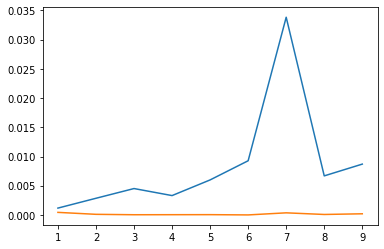

In [390]:
# Plot them
plt.plot(range(1, 10), o1_errors)
plt.plot(range(1, 10), o2_errors)

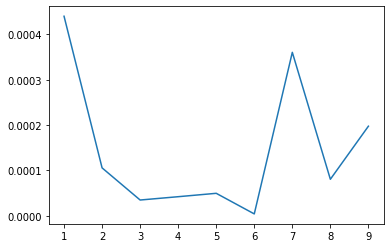

In [391]:

plt.plot(range(1, 10), o2_errors)

# How changes in an end of circuit error map effect changes in output probabilities for an arbitrary qubit state

In [11]:
import pygsti.modelpacks.smq1Q_XYZI as std
mdl = std.target_model('TP')
print('mu0: ', mdl['Mdefault']['0'].to_dense())
print('mu1: ', mdl['Mdefault']['1'].to_dense())
print('rho0:' ,mdl['rho0'].to_dense())

mu0:  [0.70710678 0.         0.         0.70710678]
mu1:  [ 0.70710678  0.          0.         -0.70710678]
rho0: [0.70710678 0.         0.         0.70710678]


In [12]:
egen = ErrorGen(1)
egen.mat

bloch_vec = [0, 1, 0] # x, y, z
rho = np.array([1, bloch_vec[0], bloch_vec[1], bloch_vec[2]])
rho = sp.Matrix(rho/np.sqrt(rho@rho))

mu0 = sp.Matrix((1/np.sqrt(2))*np.array([1, 0, 0, 1])).T
mu1 = sp.Matrix((1/np.sqrt(2))*np.array([1, 0, 0,-1])).T

In [13]:
mu0

Matrix([[0.707106781186547, 0.0, 0.0, 0.707106781186547]])

In [14]:
mu0@egen.mat@rho

Matrix([[-2.0*{A}^{XxY}_{Gq0} + 1.0*{C}^{YxZ}_{Gq0} + 1.0*{H}^{X}_{Gq0}]])

In [15]:
mu1@egen.mat@rho

Matrix([[2.0*{A}^{XxY}_{Gq0} - 1.0*{C}^{YxZ}_{Gq0} - 1.0*{H}^{X}_{Gq0}]])

# 1 qubit demo

In [16]:
import pygsti.modelpacks.smq1Q_XYZI as std
#import pygsti.modelpacks.smq2Q_XYCNOT as std
edesign = std.create_gst_experiment_design(16)
gs = GateSet(std)

In [17]:
circ_list = edesign.circuit_lists[-1]
circ = circ_list[-1]

In [18]:
len(circ_list)

1222

In [19]:
print(circ)

Qubit 0 ---|Gypi2|-|Gypi2|-|Gypi2|-|Gxpi2|-|Gypi2|-|Gzpi2|-|Gxpi2|-|Gypi2|-|Gzpi2|-|Gxpi2|-|Gypi2|-|Gzpi2|-|Gxpi2|-|Gypi2|-|Gzpi2|-|Gxpi2|-|Gypi2|-|Gzpi2|-|Gypi2|-|Gypi2|-|Gypi2|---



In [20]:
len(circ)

21

In [21]:
ca = CircuitAnalyzer(circ, gs)

In [22]:
ca.linear_F_map()

Matrix([
[                                                                                                         0,                                                                                                                                                                                                                           0,                                                                                                                                                                                                     0,                                                                                                                                                                                                                           0],
[                              -4.0*{A}^{XxY}_{Gypi2q0} + 4.0*{A}^{XxY}_{Gzpi2q0} - 4.0*{A}^{YxZ}_{Gxpi2q0}, -4.0*{S}^{X}_{Gxpi2q0} - 14.0*{S}^{X}_{Gypi2q0} - 6.0*{S}^{X}_{Gzpi2q0} - 6.0*{S}^{Y}_{Gxpi2q0} - 18.0*{S}^{Y}_{Gypi2q0} - 10.0*{S}

In [23]:
from IPython.display import display
egenlbls = LindbladErrorgen.from_error_generator(4**1).coefficient_labels()
for lbl in egenlbls:
    print(lbl) 
    display(ca.linear_variation(lbl))

H(X:0)


1.0*{H}^{X}_{Gxpi2q0} + 1.0*{H}^{Z}_{Gypi2q0} - 1.0*{H}^{Z}_{Gzpi2q0}

H(Y:0)


5.0*{H}^{X}_{Gypi2q0} + 6.0*{H}^{Y}_{Gypi2q0} + 5.0*{H}^{Y}_{Gzpi2q0} + 5.0*{H}^{Z}_{Gxpi2q0}

H(Z:0)


-2.0*{H}^{X}_{Gypi2q0} + 1.0*{H}^{X}_{Gzpi2q0} - 1.0*{H}^{Y}_{Gxpi2q0} - 1.0*{H}^{Y}_{Gypi2q0}

S(X:0)


3.0*{S}^{X}_{Gxpi2q0} + 4.0*{S}^{X}_{Gypi2q0} + 2.0*{S}^{X}_{Gzpi2q0} + 2.0*{S}^{Y}_{Gxpi2q0} + 2.0*{S}^{Y}_{Gypi2q0} + 5.0*{S}^{Z}_{Gypi2q0} + 3.0*{S}^{Z}_{Gzpi2q0}

C(X,Y:0)


1.0*{C}^{XxZ}_{Gxpi2q0} - 1.0*{C}^{XxZ}_{Gypi2q0} + 2.0*{C}^{YxZ}_{Gypi2q0} - 1.0*{C}^{YxZ}_{Gzpi2q0}

A(X,Y:0)


1.0*{A}^{XxZ}_{Gxpi2q0} + 1.0*{A}^{XxZ}_{Gypi2q0} - 2.0*{A}^{YxZ}_{Gypi2q0} + 1.0*{A}^{YxZ}_{Gzpi2q0}

C(X,Z:0)


-1.0*{C}^{XxY}_{Gxpi2q0} + 2.0*{C}^{XxZ}_{Gypi2q0} - 1.0*{C}^{XxZ}_{Gzpi2q0} + 1.0*{C}^{YxZ}_{Gypi2q0}

A(X,Z:0)


-5.0*{A}^{XxY}_{Gxpi2q0} + 6.0*{A}^{XxZ}_{Gypi2q0} + 5.0*{A}^{XxZ}_{Gzpi2q0} - 5.0*{A}^{YxZ}_{Gypi2q0}

S(Y:0)


5.0*{S}^{X}_{Gypi2q0} + 6.0*{S}^{Y}_{Gypi2q0} + 5.0*{S}^{Y}_{Gzpi2q0} + 5.0*{S}^{Z}_{Gxpi2q0}

C(Y,Z:0)


-3.0*{C}^{XxY}_{Gypi2q0} + 1.0*{C}^{XxY}_{Gzpi2q0} - 1.0*{C}^{YxZ}_{Gxpi2q0}

A(Y,Z:0)


1.0*{A}^{XxY}_{Gypi2q0} - 1.0*{A}^{XxY}_{Gzpi2q0} + 1.0*{A}^{YxZ}_{Gxpi2q0}

S(Z:0)


2.0*{S}^{X}_{Gxpi2q0} + 2.0*{S}^{X}_{Gypi2q0} + 3.0*{S}^{X}_{Gzpi2q0} + 3.0*{S}^{Y}_{Gxpi2q0} + 3.0*{S}^{Y}_{Gypi2q0} + 6.0*{S}^{Z}_{Gypi2q0} + 2.0*{S}^{Z}_{Gzpi2q0}

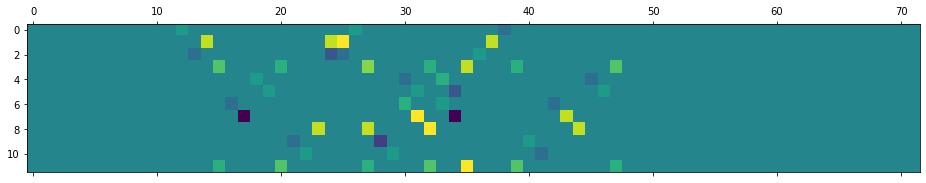

In [24]:
plt.matshow(ca.variation_matrix())

In [25]:
gs.vec

[{H}^{X}_{()q},
 {H}^{Y}_{()q},
 {H}^{Z}_{()q},
 {S}^{X}_{()q},
 {C}^{XxY}_{()q},
 {A}^{XxY}_{()q},
 {C}^{XxZ}_{()q},
 {A}^{XxZ}_{()q},
 {S}^{Y}_{()q},
 {C}^{YxZ}_{()q},
 {A}^{YxZ}_{()q},
 {S}^{Z}_{()q},
 {H}^{X}_{Gxpi2q0},
 {H}^{Y}_{Gxpi2q0},
 {H}^{Z}_{Gxpi2q0},
 {S}^{X}_{Gxpi2q0},
 {C}^{XxY}_{Gxpi2q0},
 {A}^{XxY}_{Gxpi2q0},
 {C}^{XxZ}_{Gxpi2q0},
 {A}^{XxZ}_{Gxpi2q0},
 {S}^{Y}_{Gxpi2q0},
 {C}^{YxZ}_{Gxpi2q0},
 {A}^{YxZ}_{Gxpi2q0},
 {S}^{Z}_{Gxpi2q0},
 {H}^{X}_{Gypi2q0},
 {H}^{Y}_{Gypi2q0},
 {H}^{Z}_{Gypi2q0},
 {S}^{X}_{Gypi2q0},
 {C}^{XxY}_{Gypi2q0},
 {A}^{XxY}_{Gypi2q0},
 {C}^{XxZ}_{Gypi2q0},
 {A}^{XxZ}_{Gypi2q0},
 {S}^{Y}_{Gypi2q0},
 {C}^{YxZ}_{Gypi2q0},
 {A}^{YxZ}_{Gypi2q0},
 {S}^{Z}_{Gypi2q0},
 {H}^{X}_{Gzpi2q0},
 {H}^{Y}_{Gzpi2q0},
 {H}^{Z}_{Gzpi2q0},
 {S}^{X}_{Gzpi2q0},
 {C}^{XxY}_{Gzpi2q0},
 {A}^{XxY}_{Gzpi2q0},
 {C}^{XxZ}_{Gzpi2q0},
 {A}^{XxZ}_{Gzpi2q0},
 {S}^{Y}_{Gzpi2q0},
 {C}^{YxZ}_{Gzpi2q0},
 {A}^{YxZ}_{Gzpi2q0},
 {S}^{Z}_{Gzpi2q0},
 {H}^{X}_{MdefaultqM},
 {H}^{Y}_{Mdefaul

# 2 qubit demo

In [26]:
import pygsti.modelpacks.smq2Q_XYCNOT as std
edesign = std.get_gst_experiment_design(16)
gs = GateSet(std)

/Users/cnammour/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pygsti/tools/legacytools.py:38: UserWarning: The function get_gst_experiment_design is deprecated, and may not be present in future versions of pygsti.
    Please use create_gst_experiment_design instead.
  _warnings.warn(message)


In [27]:
std.gates

[('Gxpi2', 1), ('Gypi2', 1), ('Gxpi2', 0), ('Gypi2', 0), ('Gcnot', 0, 1)]

In [28]:
circ = Circuit([('Gxpi2', 0), ('Gcnot', 0, 1)])

In [29]:
print(circ)

Qubit 0 ---|Gxpi2|-|C1|---
Qubit 1 ---|     |-|T0|---



In [30]:
ca = CircuitAnalyzer(circ, gs)

In [31]:
ca.linear_F_map()

Matrix([
[                                                                                                                                                                                                                             0,                                                                                                                                                                                                                                                                                                                                                                                                                                                        0,                                                                                                                                                                                                                                                                                                                                     